In [1]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import seaborn as sns

from collections import Counter
from diversity import Metacommunity
from itertools import combinations
from matplotlib import pyplot as plt, patches
from os import listdir, mkdir, path
from os.path import expanduser
from scipy.stats import linregress
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import pickle

In [2]:
cmap = "bone_r"

### Data Wrangling

In [3]:
#Loading the images
with open('downscaled_arr_hash.pkl','rb') as f:
    arr_hash = pickle.load(f)

In [4]:
#Defining the out-directory

outdir = "medical_imaging_outdir"
if not path.isdir(outdir):
    mkdir(outdir)

In [5]:
#Create list of filenames of images from keys of arr_hash
image_list=[]

for filename in arr_hash.keys():
    image_list.append(filename)

In [6]:
set([i.split(".")[0].rsplit("_")[-1] for i in image_list])

{'3VT', '3VV', 'A4C', 'A5C', 'ABDO'}

In [7]:
#List first 10 images
image_list[:10]

['379481851_60_24_A4C.png',
 '425809275_67_1_A4C.png',
 '103464152_25_46_A4C.png',
 '307885319_17_15_A5C.png',
 '425809275_67_19_A4C.png',
 '086179587_74_5_3VV.png',
 '425809275_67_20_A4C.png',
 '379481851_60_48_A4C.png',
 '307885319_17_3_A5C.png',
 '379481851_60_53_A4C.png']

In [8]:
n = len(image_list)
n

137

In [9]:
image_list[-1]

'425809275_62_10_A4C.png'

In [10]:
#Removing the last image from image_list, so that there is an even number of images
image_list = image_list[:136]

In [11]:
n = len(image_list)
n

136

In [12]:
#Creating a list of arrays (one for each image) from the values of arr_hash:

arr_list = []

for filename in image_list:
    arr_list.append(arr_hash[filename])
arr_list = np.array(arr_list)

In [13]:
arr_list.shape

(136, 80, 80)

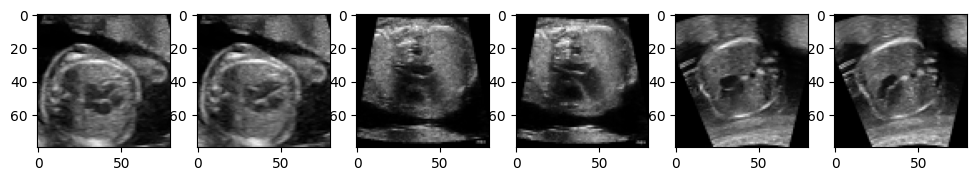

In [14]:
#Show a few pairs of images which are similar to each other
image_example =   arr_list[54]
image_example_2 = arr_list[31]
image_example_3 = arr_list[116]
image_example_4 = arr_list[65]
image_example_5 = arr_list[2]
image_example_6 = arr_list[68]
fig, axs = plt.subplots(ncols=6, figsize=(12,3))
axs[0].imshow(image_example,   cmap="gray")
axs[1].imshow(image_example_2, cmap="gray")
axs[2].imshow(image_example_3, cmap="gray")
axs[3].imshow(image_example_4, cmap="gray")
axs[4].imshow(image_example_5, cmap="gray")
axs[5].imshow(image_example_6, cmap="gray")
plt.show()

We indeed see that the first two images are very similar, and so on.

In [15]:
rmse = np.sqrt(np.mean((image_example - image_example_2)**2))
sim = np.exp(-rmse)
sim

0.9454358

In [16]:
#Listing the views of images

views = pd.Series([i.split(".")[0].rsplit("_")[-1] for i in image_list])

In [17]:
views

0      A4C
1      A4C
2      A4C
3      A5C
4      A4C
      ... 
131    A4C
132    A4C
133    A5C
134    3VV
135    A4C
Length: 136, dtype: object

In [18]:
class_balance = dict(Counter(views))

class_balance = {i: class_balance[i] for i in sorted(list(class_balance.keys()), reverse=True)}

class_balance

{'ABDO': 4, 'A5C': 35, 'A4C': 56, '3VV': 37, '3VT': 4}

In [19]:
#Computing the Shannon entropy of the class balance

def Shannon_ent(probs):
    Shannon_ent = 0
    for prob in probs:
        Shannon_ent += -prob*np.log(prob)
    return Shannon_ent

In [20]:
Shannon_ent([value/n for value in class_balance.values()])

1.2762490438971308

In [21]:
#1 image from each class

for view in class_balance.keys():
    for i in range(n):
        if views[i] == view:
            print((i, image_list[i]))
            break 

(37, '425809275_3_7_ABDO.png')
(3, '307885319_17_15_A5C.png')
(0, '379481851_60_24_A4C.png')
(5, '086179587_74_5_3VV.png')
(16, '086179587_74_2_3VT.png')


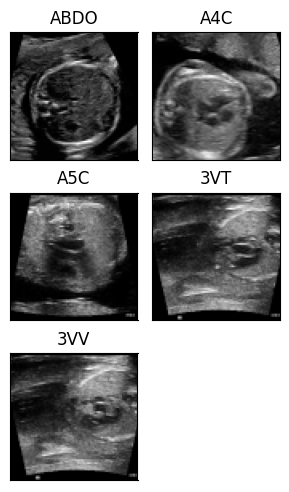

In [22]:
ix_view_pairs = (
    (37, "ABDO"),
    (0, "A4C"),
    (3, "A5C"),
    (16, "3VT"),
    (5, "3VV"),
)
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(3,5))
for ii, (ix, view) in enumerate(ix_view_pairs):
    i = ii//2
    j = ii % 2
    axs[i][j].imshow(arr_list[ix], cmap="gray")
    axs[i][j].set_title(view)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
axs[2][1].set_xticks([])
axs[2][1].set_yticks([])
axs[2][1].axis("off")
plt.tight_layout()
plt.savefig(outdir + "/medical_imaging_fig6a.pdf")
plt.show()

In [23]:
arr_list.shape

(136, 80, 80)

### Similarity definition: RMSE

In [24]:
def rmse_similarity(img1, img2):
    rmse = np.sqrt(np.mean((img1 - img2)**2))
    sim = np.exp(-rmse)
    return sim

In [25]:
sim_array = np.zeros(shape=(n, n))
for i in tqdm(range(n)):
    for j in range(i, n):
        sim = rmse_similarity(arr_list[i], arr_list[j])
        sim_array[i][j] = sim
        sim_array[j][i] = sim

  0%|          | 0/136 [00:00<?, ?it/s]

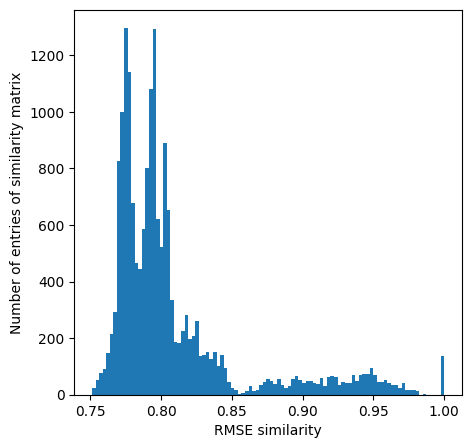

In [26]:
#Histogram of RMSE similarity 
plt.figure(figsize=(5,5))
plt.hist(sim_array.ravel(), bins = np.linspace(min(sim_array.ravel()),1,100))
plt.xlabel("RMSE similarity")
plt.ylabel("Number of entries of similarity matrix")
plt.show()

In [27]:
sim_array_rescaled = sim_array - sim_array.ravel().min()
sim_array_rescaled = sim_array_rescaled*(1/sim_array_rescaled.max())

In [28]:
lut = {"ABDO": "black", 
       "A4C": "#444", 
       "A5C": "#888", 
       "3VT": "#ccc", 
       "3VV": "white"
      }

In [29]:
sim_array_rescaled.shape

(136, 136)

<Figure size 640x480 with 0 Axes>

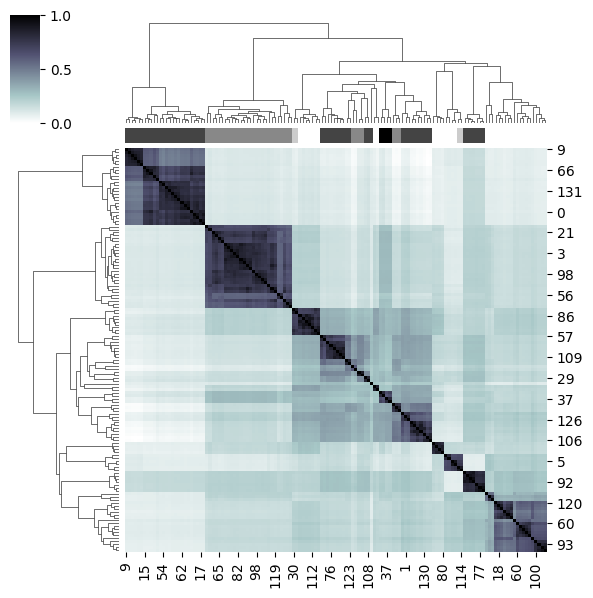

In [30]:
figsize = (6, 6)
edge_color = "white"
lw = 2
ls = ":"

rects = (
#     (( 0,  0), 26, 26),
#     ((26, 26), 28, 28),
#     ((54, 54), 20, 20),
#     ((74, 74), 10, 10),
#     ((84, 84), 52, 52),
)

plt.figure()
p = sns.clustermap(sim_array_rescaled, 
                   cmap=cmap, 
                   col_colors=views.map(lut).to_numpy(),
                   figsize=figsize)
for rect in rects:
    p.ax_heatmap.add_patch(patches.Rectangle(*rect, edgecolor=edge_color, facecolor='none', lw=lw, ls=ls))
# p.ax_heatmap.set_xticks([])
# p.ax_heatmap.set_yticks([])
p.ax_heatmap.grid(False)
plt.savefig(outdir + "/medical_imaging_fig6b.pdf")
plt.show()

## Split \#1: Subset A vs. Subset B

<Figure size 640x480 with 0 Axes>

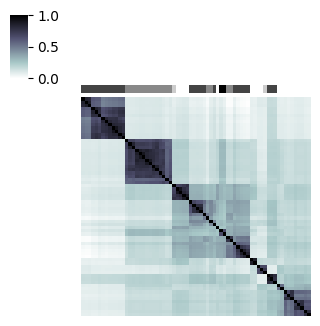

<Figure size 640x480 with 0 Axes>

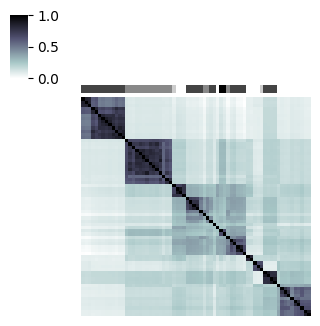

In [31]:
clustered_list = p.dendrogram_row.reordered_ind
odds  = clustered_list[0:None:2]
evens = clustered_list[1:None:2]
odds_colors  = views[odds].map(lut).to_numpy()
evens_colors = views[evens].map(lut).to_numpy()
simarray_odds  = sim_array_rescaled[odds, :][:, odds]
simarray_evens = sim_array_rescaled[evens, :][:, evens]

# Clustermap for subcommunities A and B---note: do not actually cluster!

# A
figsize=(3.5, 3.5)
plt.figure()
r1 = sns.clustermap(simarray_odds,  cmap=cmap, row_cluster=False, col_cluster=False, 
                    col_colors=odds_colors,  figsize=figsize, vmin=0, vmax=1)
r1.ax_heatmap.set_xticks([])
r1.ax_heatmap.set_yticks([])
r1.ax_heatmap.grid(False)
plt.savefig(outdir + "/medical_imaging_fig7a.pdf")
plt.show()

# B
figsize=(3.5, 3.5)
plt.figure()
r2 = sns.clustermap(simarray_evens, cmap=cmap, row_cluster=False, col_cluster=False, 
                    col_colors=evens_colors, figsize=figsize, vmin=0, vmax=1)
r2.ax_heatmap.set_xticks([])
r2.ax_heatmap.set_yticks([])
r2.ax_heatmap.grid(False)
plt.savefig(outdir + "/medical_imaging_fig7b.pdf")
plt.show()

In [32]:
# Count the number of views in each subcommunity

viewcounts_A = Counter(views[odds])
viewcounts_B = Counter(views[evens])
print("odds (A):",  viewcounts_A.most_common())
print("evens (B):", viewcounts_B.most_common())

Shannon_ent([value/len(odds)  for value in viewcounts_A.values()]), Shannon_ent([value/len(evens) for value in viewcounts_B.values()])

odds (A): [('A4C', 27), ('3VV', 19), ('A5C', 18), ('3VT', 2), ('ABDO', 2)]
evens (B): [('A4C', 29), ('3VV', 18), ('A5C', 17), ('3VT', 2), ('ABDO', 2)]


(1.2822839353136068, 1.2692799657211924)

In [33]:
# Compute R-squared
r_squared_partition_1 = linregress(list(viewcounts_A.values()), list(viewcounts_B.values())).rvalue**2
r_squared_partition_1

0.9899129840434799

In [34]:
#Create a dataframe to store the frequency of each image in each subcommunity.
#Because each image is unique, all frequencies are either 1 or 0.

counts_1 = pd.DataFrame(
    {
      "Odd-numbered":  [ clustered_list.index(i)      % 2 for i in range(n)],
      "Even-numbered": [(clustered_list.index(i) + 1) % 2 for i in range(n)]
    }
)

In [35]:
# Create a metacommunity object from the count dataframe and the similarity matrix above
metacommunity = Metacommunity(counts_1, similarity=sim_array_rescaled)

#Print out the diversity at viewpoint parameter q=0
df_1 = metacommunity.to_dataframe(viewpoint=[0, 1, np.inf])
df_1_reduced = df_1[['rho', 'normalized_rho', 'beta', 'normalized_beta']].iloc[1:3,:].T
df_1_reduced.loc['rho_hat'] = df_1_reduced.loc['rho'] - 1
df_1_reduced.loc['beta_hat'] = df_1_reduced.loc['beta']*2 - 1
df_1_reduced.columns = ['Subcommunity A', 'Subcommunity B']
df_1_reduced

,Subcommunity A,Subcommunity B
rho,1.988751,1.990059
normalized_rho,0.994375,0.995029
beta,0.502828,0.502498
normalized_beta,1.005656,1.004996
rho_hat,0.988751,0.990059
beta_hat,0.005656,0.004996


In [36]:
# view
df_1

,community,viewpoint,alpha,rho,beta,gamma,normalized_alpha,normalized_rho,normalized_beta,rho_hat,beta_hat
0,metacommunity,0.0,8.740505,1.989405,0.502663,4.394364,4.370252,0.994702,1.005326,0.989405,0.005326
1,Odd-numbered,0.0,8.738776,1.988751,0.502828,4.396147,4.369388,0.994375,1.005656,0.988751,0.005656
2,Even-numbered,0.0,8.742233,1.990059,0.502498,4.392581,4.371116,0.995029,1.004996,0.990059,0.004996
3,metacommunity,1.0,8.646217,1.989306,0.502688,4.346348,4.323109,0.994653,1.005376,0.989306,0.005366
4,Odd-numbered,1.0,8.644771,1.988660,0.502851,4.347034,4.322386,0.994330,1.005703,0.988660,0.005703
5,Even-numbered,1.0,8.647664,1.989954,0.502524,4.345661,4.323832,0.994977,1.005049,0.989954,0.005049
6,metacommunity,inf,7.017036,1.937811,0.513305,3.517897,3.508518,0.968906,1.026610,0.937811,0.026610
7,Odd-numbered,inf,7.029732,1.937811,0.516046,3.517897,3.514866,0.968906,1.032092,0.937811,0.032092
8,Even-numbered,inf,7.017036,1.948160,0.513305,3.525227,3.508518,0.974080,1.026610,0.948160,0.026610


We see that the $\rho$ index is approximately 2 for both subcommunities (and for any value of the viewpoint parameter). This index is called the redundancy in Reeves, so it makes sense that it is equal to 2 because there are 2 essentially identical subcommunities in this case. This can also be seen from equations as follows:

First, we recall the definition of $\rho$:

$$
{}^{q} \rho^{Z}_{j} = M_{1-q} \left( \bar{P}_{\cdot j} ; \frac{Zp}{Z P_{\cdot j}} \right) 
$$

For $q=0$ for example, this simplifies to

$$
\rho^{Z}_{j} = \sum_{i \in \mathrm{supp}{(\bar{P}_{\cdot j})}} (\bar{P}_{\cdot j})_{i} \frac{(Zp)_{i}}{(ZP_{\cdot j})_{i}}
$$

where $\bar{P}_{\cdot j}$ is defined to be $\frac{P_{\cdot j}}{w_j}$, and the weight $w_j$ is defined to be $\sum_{i} P_{ij}$. If we substitute back into the equation above, and ignore the effect of the similarity matrix by setting it to something close to the identity matrix, then we have

$$
\rho^{Z}_{j} \approx \sum_{i} \frac{\sum_{j} P_{ij}}{\sum_{i} P_{ij}}
$$

Now, because the two communities are very similar, all the nonzero $P_{ij}$ are equal to each other. So we see that the expression above simplifies to the number of subcommunities, which is $2$ in this case.

## Split \#2: Subset C vs. Subset D

Next, we repeat for a different way to partition the metacommunity. 

In [37]:
for i, ind in enumerate(clustered_list):
    print (i, image_list[ind][-7:-4])

0 A4C
1 A4C
2 A4C
3 A4C
4 A4C
5 A4C
6 A4C
7 A4C
8 A4C
9 A4C
10 A4C
11 A4C
12 A4C
13 A4C
14 A4C
15 A4C
16 A4C
17 A4C
18 A4C
19 A4C
20 A4C
21 A4C
22 A4C
23 A4C
24 A4C
25 A4C
26 A5C
27 A5C
28 A5C
29 A5C
30 A5C
31 A5C
32 A5C
33 A5C
34 A5C
35 A5C
36 A5C
37 A5C
38 A5C
39 A5C
40 A5C
41 A5C
42 A5C
43 A5C
44 A5C
45 A5C
46 A5C
47 A5C
48 A5C
49 A5C
50 A5C
51 A5C
52 A5C
53 A5C
54 3VT
55 3VT
56 3VV
57 3VV
58 3VV
59 3VV
60 3VV
61 3VV
62 3VV
63 A4C
64 A4C
65 A4C
66 A4C
67 A4C
68 A4C
69 A4C
70 A4C
71 A4C
72 A4C
73 A5C
74 A5C
75 A5C
76 A5C
77 A4C
78 A4C
79 A4C
80 3VV
81 3VV
82 BDO
83 BDO
84 BDO
85 BDO
86 A5C
87 A5C
88 A5C
89 A4C
90 A4C
91 A4C
92 A4C
93 A4C
94 A4C
95 A4C
96 A4C
97 A4C
98 A4C
99 3VV
100 3VV
101 3VV
102 3VV
103 3VV
104 3VV
105 3VV
106 3VV
107 3VT
108 3VT
109 A4C
110 A4C
111 A4C
112 A4C
113 A4C
114 A4C
115 A4C
116 3VV
117 3VV
118 3VV
119 3VV
120 3VV
121 3VV
122 3VV
123 3VV
124 3VV
125 3VV
126 3VV
127 3VV
128 3VV
129 3VV
130 3VV
131 3VV
132 3VV
133 3VV
134 3VV
135 3VV


In [38]:
# List the original indices (as in image_list) of images belonging to subcommunity C
subcomm_C_indices = clustered_list[:26] + (clustered_list[37:54]) + (clustered_list[54:56] + clustered_list[71:73]) + \
clustered_list[82:84] + clustered_list[116:135]

In [39]:
#Listing the original indices (as in image_list) of images belonging to subcommunity D
subcomm_D_indices = [i for i in range(n) if i not in subcomm_C_indices]

In [40]:
subcomm_C_views = list(views[subcomm_C_indices])

In [41]:
subcomm_D_views = views[subcomm_D_indices]

In [42]:
# Count the number of views in each subcommunity and store the results in a sorted dictionary

viewcounts_C = dict(Counter(subcomm_C_views))
viewcounts_D = dict(Counter(subcomm_D_views))

viewcounts_C = {i: viewcounts_C[i] for i in sorted(list(viewcounts_C.keys()), reverse=True)}
viewcounts_D = {i: viewcounts_D[i] for i in sorted(list(viewcounts_D.keys()), reverse=True)}

In [43]:
viewcounts_C

{'ABDO': 2, 'A5C': 17, 'A4C': 28, '3VV': 19, '3VT': 2}

In [44]:
viewcounts_D

{'ABDO': 2, 'A5C': 18, 'A4C': 28, '3VV': 18, '3VT': 2}

In [45]:
r_squared_partition_2 = linregress(list(viewcounts_C.values()), list(viewcounts_D.values())).rvalue**2
r_squared_partition_2

0.9961330239752509

In [46]:
def subcomm_C_check(i):
    if i in subcomm_C_indices:
        return 1
    else:
        return 0

counts_2 = pd.DataFrame(
    {
      "Subcommunity C": [subcomm_C_check(i) for i in range(len(image_list))],
    }
)

counts_2['Subcommunity D'] = (counts_2['Subcommunity C'] + 1) % 2

In [47]:
counts_2

,Subcommunity C,Subcommunity D
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
131,1,0
132,0,1
133,0,1
134,0,1


In [48]:
subcomm_C = list(filter(lambda filename: counts_2.loc[image_list.index(filename),'Subcommunity C'] ,image_list))
subcomm_D = list(filter(lambda filename: counts_2.loc[image_list.index(filename),'Subcommunity D'] ,image_list))

n_C = len(subcomm_C)
n_D = len(subcomm_D)

arr_list_C = list(map(lambda filename: arr_hash[filename], subcomm_C))
arr_list_D = list(map(lambda filename: arr_hash[filename], subcomm_D))

In [49]:
sim_array_C = np.zeros(shape=(n_C, n_C))
for i in tqdm(range(n_C)):
    for j in range(i, n_C):
        sim = rmse_similarity(arr_list_C[i], arr_list_C[j])
        sim_array_C[i][j] = sim
        sim_array_C[j][i] = sim

sim_array_D = np.zeros(shape=(n_D, n_D))
for i in tqdm(range(n_D)):
    for j in range(i, n_D):
        sim = rmse_similarity(arr_list_D[i], arr_list_D[j])
        sim_array_D[i][j] = sim
        sim_array_D[j][i] = sim

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

In [50]:
sim_array_C = (sim_array_C - sim_array.ravel().min())/(sim_array.ravel().max() - sim_array.ravel().min())
sim_array_D = (sim_array_D - sim_array.ravel().min())/(sim_array.ravel().max() - sim_array.ravel().min())

In [51]:
views_C = pd.Series([views[image_list.index(subcomm_C[i])] for i in range(n_C)])
views_D = pd.Series([views[image_list.index(subcomm_D[i])] for i in range(n_D)])

In [52]:
dict(Counter(views_C)).values()

dict_values([28, 19, 17, 2, 2])

In [53]:
Shannon_ent([value/n_C for value in dict(Counter(views_C)).values()])

1.2756359042898782

In [54]:
Shannon_ent([value/n_D for value in dict(Counter(views_D)).values()])

1.276453318537762

<Figure size 640x480 with 0 Axes>

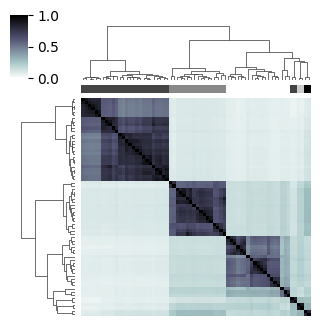

<Figure size 640x480 with 0 Axes>

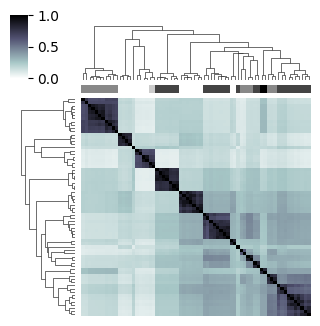

In [55]:
# Clustermaps for subcommunities C and D

figsize=(3.5, 3.5)

# C
plt.figure()
q1 = sns.clustermap(sim_array_C, cmap=cmap, col_colors = views_C.map(lut).to_numpy(), figsize=figsize, 
                    vmin=0, vmax=1)
q1.ax_heatmap.set_xticks([])
q1.ax_heatmap.set_yticks([])
q1.ax_heatmap.grid(False)
plt.savefig(outdir + "/medical_imaging_fig7c.pdf")
plt.show()

# D
plt.figure()
q2 = sns.clustermap(sim_array_D, cmap=cmap, col_colors = views_D.map(lut).to_numpy(), figsize=figsize, 
                    vmin=0, vmax=1)
q2.ax_heatmap.set_xticks([])
q2.ax_heatmap.set_yticks([])
q2.ax_heatmap.grid(False)
plt.savefig(outdir + "/medical_imaging_fig7d.pdf")
plt.show()

In [56]:
#Creating the metacommunity object 
metacommunity_2 = Metacommunity(counts_2, similarity=sim_array_rescaled)

In [57]:
#Print out the diversity at q=0
df_2 = metacommunity_2.to_dataframe(viewpoint=[0, 1, np.inf])
df_2_reduced = df_2[['rho', 'normalized_rho', 'beta', 'normalized_beta']].iloc[1:3,:].T
df_2_reduced.loc['rho_hat'] = df_2_reduced.loc['rho'] - 1
df_2_reduced.loc['beta_hat'] = df_2_reduced.loc['beta']*2 - 1
df_2_reduced.columns = ['Subcommunity C', 'Subcommunity D']
df_2_reduced

,Subcommunity C,Subcommunity D
rho,1.703102,1.659558
normalized_rho,0.851551,0.829779
beta,0.587164,0.602570
normalized_beta,1.174328,1.205140
rho_hat,0.703102,0.659558
beta_hat,0.174328,0.205140


In [58]:
#Full diversity dataset

df_2

,community,viewpoint,alpha,rho,beta,gamma,normalized_alpha,normalized_rho,normalized_beta,rho_hat,beta_hat
0,metacommunity,0.0,7.318352,1.681330,0.594867,4.394364,3.659176,0.840665,1.189734,0.681330,0.189734
1,Subcommunity C,0.0,7.340780,1.703102,0.587164,4.369186,3.670390,0.851551,1.174328,0.703102,0.174328
2,Subcommunity D,0.0,7.295924,1.659558,0.602570,4.419543,3.647962,0.829779,1.205140,0.659558,0.205140
3,metacommunity,1.0,7.186028,1.653349,0.604833,4.346348,3.593014,0.826674,1.209666,0.653325,0.209613
4,Subcommunity C,1.0,7.204530,1.660469,0.602240,4.338853,3.602265,0.830234,1.204479,0.660469,0.204479
5,Subcommunity D,1.0,7.167573,1.646259,0.607438,4.353855,3.583787,0.823130,1.214876,0.646259,0.214876
6,metacommunity,inf,5.729509,1.269716,0.707461,3.517897,2.864755,0.634858,1.414922,0.269716,0.414922
7,Subcommunity C,inf,5.729509,1.269716,0.787578,3.533192,2.864755,0.634858,1.575155,0.269716,0.575155
8,Subcommunity D,inf,5.821571,1.413505,0.707461,3.517897,2.910785,0.706753,1.414922,0.413505,0.414922


In [59]:
keys = ['ABDO', 'A4C', 'A5C', '3VT', '3VV']

In [60]:
viewcounts_A

Counter({'A4C': 27, 'A5C': 18, '3VT': 2, '3VV': 19, 'ABDO': 2})

In [61]:
class_prob_A = {}
n_A = np.sum(list(viewcounts_A.values()))

for view in keys:
    class_prob_A[view] = viewcounts_A[view]/n_A

In [62]:
class_prob_B = {}
n_B = np.sum(list(viewcounts_B.values()))

for view in keys:
    class_prob_B[view] = viewcounts_B[view]/n_B

In [63]:
class_prob_C = {}
n_C = np.sum(list(viewcounts_C.values()))

for view in keys:
    class_prob_C[view] = viewcounts_C[view]/n_C

In [64]:
class_prob_D = {}
n_D = np.sum(list(viewcounts_D.values()))

for view in keys:
    class_prob_D[view] = viewcounts_D[view]/n_D

In [65]:
class_prob = {}
n = np.sum(list(class_balance.values()))

for view in keys:
    class_prob[view] = class_balance[view]/n

In [66]:
colors = (
    "black", 
    "#ccc", 
    "#888", 
    "#444", 
    "white"
    )

colors = (
    "tab:blue", 
    "tab:orange", 
    "tab:green", 
    "tab:red", 
    "tab:purple"
)

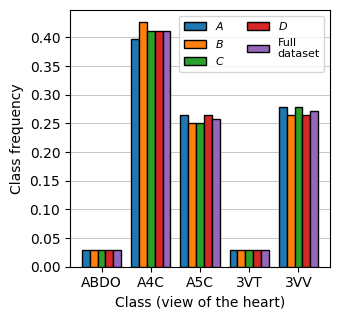

In [67]:
X_axis = np.arange(5)

gap = 0.2
width = (1-gap)/5

plt.figure(figsize=(3.5, 3.3))
plt.bar(X_axis-2*width, class_prob_A.values(), width, label='$A$',          color=colors[0], 
        edgecolor="black", zorder=1000)
plt.bar(X_axis-1*width, class_prob_B.values(), width, label='$B$',          color=colors[1], 
        edgecolor="black", zorder=1000)
plt.bar(X_axis+0*width, class_prob_C.values(), width, label='$C$',          color=colors[2], 
        edgecolor="black", zorder=1000)
plt.bar(X_axis+1*width, class_prob_D.values(), width, label='$D$',          color=colors[3], 
        edgecolor="black", zorder=1000)
plt.bar(X_axis+2*width, class_prob.values(),   width, label='Full\ndataset', color=colors[4], 
        edgecolor="black", zorder=1000)

plt.xticks(X_axis, keys)
plt.xlabel("Class (view of the heart)")
plt.ylabel('Class frequency')
plt.grid(lw=0.5, axis="y", zorder=-1000)
# plt.title("Class frequencies")
plt.legend(fontsize=8, ncols=2)
plt.tight_layout()
plt.savefig(outdir + "/medical_imaging_fig7e.pdf")
plt.show()

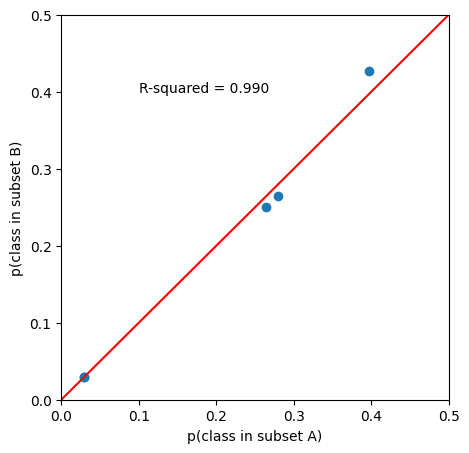

In [68]:
plt.figure(figsize=(5, 5))
plt.scatter(x=class_prob_A.values(), y=class_prob_B.values())
plt.annotate("R-squared = {:.3f}".format(r_squared_partition_1), (0.1, 0.4))
plt.plot([0,0.5],[0,0.5],color='red')
plt.xlim([0, 0.5])
plt.ylim([0, 0.5])
plt.xlabel("p(class in subset A)")
plt.ylabel("p(class in subset B)")
plt.show()

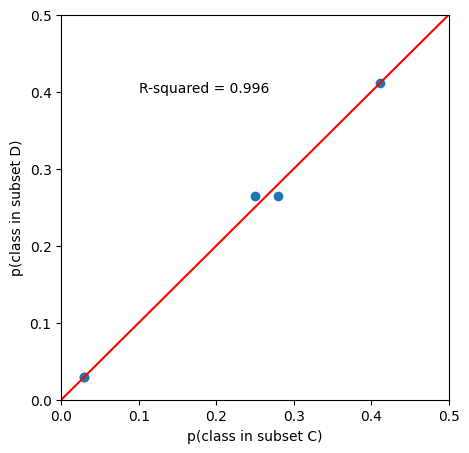

In [69]:
plt.figure(figsize=(5, 5))
plt.scatter(x= class_prob_C.values(), y= class_prob_D.values())
plt.annotate("R-squared = {:.3f}".format(r_squared_partition_2), (0.1, 0.4))
plt.plot([0,0.5],[0,0.5],color='red')
plt.xlim([0, 0.5])
plt.ylim([0, 0.5])
plt.xlabel("p(class in subset C)")
plt.ylabel("p(class in subset D)")
plt.show()